# Multivariate TDE-HMM on all subjects, following Quinn's method

## Libraries and methods

In [1]:
import numpy as np
from loader import load_oneIC
import h5py
import xarray as xr

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from hmmlearn import hmm
import scipy.signal as signal
import pickle

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from wavelet_transform import wavelet_transform2

In [4]:
import mne

In [5]:
import time as tm

In [6]:
directory = "/home/INT/malfait.n/Documents/NIC_250819"
file = "FCK_LOCKED_IC_JYOTIKA_250819.mat"

path = f"{directory}/{file}"

mat_file = h5py.File(path, "r")
cells_refs = mat_file['FCK_LOCKED_IC_JYOTIKA']

n_IC = 4
n_subj = 23

In [7]:
target_dir = "tde-hmm2/test_grids/"

## Functions

In [8]:
# The embedx function copies the `x` array len(lags) times into `xe`
# with lags (i.e. time delays) between lags[0] and lags[-1] (we implement the time-delay array for the HMM).

def embedx(x, lags):
    
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid

In [9]:
def statesPSD(gamma, n_states, xe, fs=256/3):

    psd_all = []
    for i in range(n_states):

        # Compute PSD separately for each lag
        tot = []
        for seg in xe[gamma[:, i]>(2/3), :].T:
            freqs, psd = signal.welch(x=seg, fs=fs, nfft=1000)
            tot.append(psd)
        psd = np.mean(np.asarray(tot), 0)
        psd_all.append(psd)
    
    psd_all = np.asarray(psd_all)
    
    return freqs, psd_all

## Final Script

#### Model and parameters:
|_ (??delays x 4IC)  x (7s x 256Hz x Ntrials)   -----PCA-----> |_ (??components x 4IC) x (7s x 256Hz x Ntrials) -----> |_ TDE-HMM ( 1 Gaussian/state, 3 to 6 states )

In [10]:
# The parameters we change to hope for some results
lags = np.arange(-5, 5)
n_lags = lags.shape[0]
n_iter=100
n_states_max=6    # for the Hidden Markov Model
n_components=0     # For the principal component analysis
covariance_type='full'
model_type='GaussianHMM'
tol=0.01
n_mix=1
downsamp_rate = 3

In [44]:
subj_list = [3, 4, 6, 7, 8, 10, 11, 14, 16, 18, 19, 22]

In [45]:
n_states = 3

In [48]:
file = open(f"tde-hmm2/test_files/suAll_lg{n_lags}co{n_components}st{n_states}"
                +f"{n_mix}"+model_type+"_woPCA_preModel.pkl", "rb")
model = pickle.load(file)
model.init_params = ''

for subj in subj_list:
    # Loading all data for subject{subj}
    print("Computing the imput matrix for the model")
    xeall = []
    IC_list = []
    for IC in range(1, n_IC+1):
        try:
            data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
            big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i][::downsamp_rate] for i in range(n_trials)])
                # Downsampled to 256/3 = 85,33333Hz
            big_timecourse = scale(big_timecourse)
            x = big_timecourse.reshape(-1, 1)
            xe, valid = embedx(x, lags)
            xeall.append(xe[0, :, :])
            IC_list.append(IC)
            print(f"IC{IC} loaded")
        except:
            pass
    y = np.concatenate(xeall, axis=1)
    start_time = tm.time()
    print("Computing and saving the model")
    model.fit(y)
    gamma = model.predict_proba(y)
    with open(f"tde-hmm2/test_files/su{subj}All_lg{n_lags}co{n_components}st{n_states}"
                +f"{n_mix}"+model_type+"_model.pkl", "wb") as file: pickle.dump(model, file)
    print("%s seconds" % (tm.time() - start_time))
    print("Computing the PSD of each state")
    psds = []
    for i in range(len(IC_list)):
        freqs, psd = statesPSD(gamma, n_states, xeall[i])
        psd = psd[np.newaxis,]
        psds.append(psd)
    # Save the states timecourses and PSDs thanks to xarray and netCDF
    print("Saving the states timecourses and PSDs")
    tcourse = np.concatenate(
        (np.zeros((abs(lags[0]),n_states)), gamma, np.zeros((lags[-1],n_states)))
    )
    time_axis = data["time_axis"][::downsamp_rate]
    t_len = time_axis.shape[0]
    tcourse_trials = np.zeros((n_trials, t_len, n_states))
    for tr in range(n_trials):
        tcourse_trials[tr] = tcourse[tr*t_len:(tr+1)*t_len]
    ds = xr.Dataset(
        {
            "states_timecourse": (("trials","time", "states"), tcourse_trials),
            "states_psd": (("IC", "states", "freq"), np.concatenate((psds))),
        },
        {
            "IC":IC_list,
            "time":time_axis,
            "states":np.arange(1, n_states+1),
            "freq": freqs,
        }
    )
    ds = ds.assign(frac_occ = (ds["states_timecourse"].sum("trials")/ds.sizes["trials"]))
    ds.to_netcdf(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc", mode="w")
    print(f"su{subj}, {n_states} states done")

Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing and saving the model
128.85983538627625 seconds
Computing the PSD of each state
Saving the states timecourses and PSDs
su3, 3 states done
Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing and saving the model
729.0252642631531 seconds
Computing the PSD of each state
Saving the states timecourses and PSDs
su4, 3 states done
Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing and saving the model
1006.8288340568542 seconds
Computing the PSD of each state
Saving the states timecourses and PS

In [49]:
widths = [14, 1, 5]
heights = [1 for i in range(n_states)] + [4,4,4,4]
gs_kw = dict(width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)
info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['eeg'])
n_trials_to_plot = 5

for subj in subj_list:
    fig, f_axes = plt.subplots(figsize=(sum(widths),sum(heights)), ncols=3, nrows=(n_states+4), constrained_layout=True,
                             gridspec_kw=gs_kw)
    ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc")
    for state in ds["states"].values:
        ax = f_axes[state-1,0]
    #         ax.set_xticks([])
        ax.plot(ds["time"].values, ds["frac_occ"].values[:, state-1], color=f"C{state-1}")
        ax.set_xlim([-4, 3])
        ax.set_ylabel(f"state {state}")
    for IC in ds["IC"].values:
        ax = f_axes[IC+n_states-1,0]
        data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
        tfr = wavelet_transform2(data, info, trial=np.arange(1,n_trials+1))
        mappable = ax.imshow(tfr[0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], 
                               norm=colors.PowerNorm(gamma=0.5), cmap='RdYlBu_r')
        ax.set_ylabel(f'Frequencies IC{IC} (Hz)')
        fig.colorbar(mappable, cax=f_axes[IC+n_states-1,1])
    #         if IC!=4:
    #             ax.set_xticks([])
    for i in range(len(ds["IC"].values)):
        IC = ds["IC"].values[i]
        ax = f_axes[IC+n_states-1,2]
        ax.plot(ds["freq"].values, ds["states_psd"].values[i,].T)
        ax.set_ylabel(f'PSD IC{IC}')
    ax = f_axes[n_states,2]
    lines = ax.get_lines()
    labels = [f"State {i}" for i in range (1, n_states+1)]
    ax = f_axes[0,2]
    ax.legend(lines, labels, loc='upper left')
    ax = f_axes[n_states+3,0]
    ax.set_xlabel(f'Time (s)') 
    ax = f_axes[n_states+3,2]
    ax.set_xlabel(f'Frequency (Hz)')   

    fig.savefig(target_dir + f'grid-{n_states}states-subj{subj}_woPCA.png', dpi=300)
    plt.close(fig)

    fig, f_axes = plt.subplots(figsize=(20,n_states*n_trials_to_plot), ncols=1, nrows=(n_states*n_trials_to_plot), constrained_layout=True)
    ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc")
    for state in range(1, n_states+1):
        color = f"C{state-1}"
        for trial in range(1, n_trials_to_plot+1):
            ax = f_axes[n_trials_to_plot*(state-1)+trial-1]
            ax.fill_between(ds["time"], ds["states_timecourse"].values[trial, :, state-1], color=color)
            ax.set_xlim([-4, 3])
            ax.set_ylim([0, 1])
            ax.set_ylabel(f"Prob. st{state} tr{trial}")
    ax.set_xlabel("Time (s)")
    fig.savefig(target_dir + f'tcourses-{n_states}states-subj{subj}_woPCA.png', dpi=300)
    plt.close(fig)

Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
L

In [50]:
subj_list = [2, 3, 4, 6, 7, 8, 10, 11, 14, 16, 18, 19, 22]

In [51]:
n_states_range = [4,5,6]

In [52]:
for subj in subj_list:
    # Loading all data for subject{subj}
    print("Computing the imput matrix for the model")
    xeall = []
    IC_list = []
    for IC in range(1, n_IC+1):
    #         try:
            data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
            big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i][::downsamp_rate] for i in range(n_trials)])
                # Downsampled to 256/3 = 85,33333Hz
            big_timecourse = scale(big_timecourse)
            x = big_timecourse.reshape(-1, 1)
            xe, valid = embedx(x, lags)
            xeall.append(xe[0, :, :])
            IC_list.append(IC)
            print(f"IC{IC} loaded")
    #         except:
    #             pass
    y = np.concatenate(xeall, axis=1)
    
    for n_states in n_states_range:
        file = open(f"tde-hmm2/test_files/suAll_lg{n_lags}co{n_components}st{n_states}"
                +f"{n_mix}"+model_type+"_woPCA_preModel.pkl", "rb")
        model = pickle.load(file)
        model.init_params = ''
        start_time = tm.time()
        print("Computing and saving the model")
        model.fit(y)
        gamma = model.predict_proba(y)
        with open(f"tde-hmm2/test_files/su{subj}All_lg{n_lags}co{n_components}st{n_states}"
                    +f"{n_mix}"+model_type+"_model.pkl", "wb") as file: pickle.dump(model, file)
        print("%s seconds" % (tm.time() - start_time))
        print("Computing the PSD of each state")
        psds = []
        for i in range(len(IC_list)):
            freqs, psd = statesPSD(gamma, n_states, xeall[i])
            psd = psd[np.newaxis,]
            psds.append(psd)
        # Save the states timecourses and PSDs thanks to xarray and netCDF
        print("Saving the states timecourses and PSDs")
        tcourse = np.concatenate(
            (np.zeros((abs(lags[0]),n_states)), gamma, np.zeros((lags[-1],n_states)))
        )
        time_axis = data["time_axis"][::downsamp_rate]
        t_len = time_axis.shape[0]
        tcourse_trials = np.zeros((n_trials, t_len, n_states))
        for tr in range(n_trials):
            tcourse_trials[tr] = tcourse[tr*t_len:(tr+1)*t_len]
        ds = xr.Dataset(
            {
                "states_timecourse": (("trials","time", "states"), tcourse_trials),
                "states_psd": (("IC", "states", "freq"), np.concatenate((psds))),
            },
            {
                "IC":IC_list,
                "time":time_axis,
                "states":np.arange(1, n_states+1),
                "freq": freqs,
            }
        )
        ds = ds.assign(frac_occ = (ds["states_timecourse"].sum("trials")/ds.sizes["trials"]))
        ds.to_netcdf(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc", mode="w")
        print(f"su{subj}, {n_states} states done")

Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing and saving the model
20943.813408851624 seconds
Computing the PSD of each state
Saving the states timecourses and PSDs
su2, 4 states done
Computing and saving the model
1112.7525720596313 seconds
Computing the PSD of each state
Saving the states timecourses and PSDs
su2, 5 states done
Computing and saving the model
1531.6148734092712 seconds
Computing the PSD of each state
Saving the states timecourses and PSDs
su2, 6 states done
Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded
Computing and saving the model
815.5569014549255 seconds
Computing the PSD of each state
Saving the states timecourses and PSDs
su3, 4 states done
Computing and saving th

Saving the states timecourses and PSDs
su22, 6 states done


In [53]:
info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['eeg'])
n_trials_to_plot = 5

for subj in subj_list:
    for n_states in n_states_range:
        widths = [14, 1, 5]
        heights = [1 for i in range(n_states)] + [4,4,4,4]
        gs_kw = dict(width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)
        fig, f_axes = plt.subplots(figsize=(sum(widths),sum(heights)), ncols=3, 
                                   nrows=(n_states+4), constrained_layout=True,
                                 gridspec_kw=gs_kw)
        ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc")
        for state in ds["states"].values:
            ax = f_axes[state-1,0]
        #         ax.set_xticks([])
            ax.plot(ds["time"].values, ds["frac_occ"].values[:, state-1], color=f"C{state-1}")
            ax.set_xlim([-4, 3])
            ax.set_ylabel(f"state {state}")
        for IC in ds["IC"].values:
            ax = f_axes[IC+n_states-1,0]
            data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
            tfr = wavelet_transform2(data, info, trial=np.arange(1,n_trials+1))
            mappable = ax.imshow(tfr[0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], 
                                   norm=colors.PowerNorm(gamma=0.5), cmap='RdYlBu_r')
            ax.set_ylabel(f'Frequencies IC{IC} (Hz)')
            fig.colorbar(mappable, cax=f_axes[IC+n_states-1,1])
        #         if IC!=4:
        #             ax.set_xticks([])
        for i in range(len(ds["IC"].values)):
            IC = ds["IC"].values[i]
            ax = f_axes[IC+n_states-1,2]
            ax.plot(ds["freq"].values, ds["states_psd"].values[i,].T)
            ax.set_ylabel(f'PSD IC{IC}')
        ax = f_axes[n_states,2]
        lines = ax.get_lines()
        labels = [f"State {i}" for i in range (1, n_states+1)]
        ax = f_axes[0,2]
        ax.legend(lines, labels, loc='upper left')
        ax = f_axes[n_states+3,0]
        ax.set_xlabel(f'Time (s)') 
        ax = f_axes[n_states+3,2]
        ax.set_xlabel(f'Frequency (Hz)')   

        fig.savefig(target_dir + f'grid-{n_states}states-subj{subj}_woPCA.png', dpi=300)
        plt.close(fig)

        fig, f_axes = plt.subplots(figsize=(20,n_states*n_trials_to_plot), ncols=1, 
                                   nrows=(n_states*n_trials_to_plot), constrained_layout=True)
        ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc")
        for state in range(1, n_states+1):
            color = f"C{state-1}"
            for trial in range(1, n_trials_to_plot+1):
                ax = f_axes[n_trials_to_plot*(state-1)+trial-1]
                ax.fill_between(ds["time"], ds["states_timecourse"].values[trial, :, state-1], color=color)
                ax.set_xlim([-4, 3])
                ax.set_ylim([0, 1])
                ax.set_ylabel(f"Prob. st{state} tr{trial}")
        ax.set_xlabel("Time (s)")
        fig.savefig(target_dir + f'tcourses-{n_states}states-subj{subj}_woPCA.png', dpi=300)
        plt.close(fig)

Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
L

## Tests

In [14]:
subj = 2

In [15]:
n_states = 3

##### Concatenate all subjects and create array with sizes

In [16]:
# Loading all data for subject{subj}
print("Computing the imput matrix for the model")
xeall = []
IC_list = []
for IC in range(1, n_IC+1):
#         try:
        data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
        big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i][::downsamp_rate] for i in range(n_trials)])
            # Downsampled to 256/3 = 85,33333Hz
        big_timecourse = scale(big_timecourse)
        x = big_timecourse.reshape(-1, 1)
        xe, valid = embedx(x, lags)
        xeall.append(xe[0, :, :])
        IC_list.append(IC)
        print(f"IC{IC} loaded")
#         except:
#             pass
y = np.concatenate(xeall, axis=1)

Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded


In [17]:
xeall[0].shape

(403641, 10)

In [20]:
start_time = tm.time()
print("Computing and saving the model")
file = open(f"tde-hmm2/test_files/suAll_lg{n_lags}co{n_components}st{n_states}"
            +f"{n_mix}"+model_type+"_woPCA_preModel.pkl", "rb")
# model = hmm.GaussianHMM(n_components=n_states, n_iter=n_iter,
#                         covariance_type=covariance_type, tol=tol)
model = pickle.load(file)
model.init_params = ''

Computing and saving the model


In [21]:
model.fit(y)
gamma = model.predict_proba(y)
with open(f"tde-hmm2/test_files/su{subj}All_lg{n_lags}co{n_components}st{n_states}"
            +f"{n_mix}"+model_type+"_model.pkl", "wb") as file: pickle.dump(model, file)
print("%s seconds" % (tm.time() - start_time))

404.5275161266327 seconds


In [22]:
print("Computing the PSD of each state")
psds = []
for i in range(len(IC_list)):
    freqs, psd = statesPSD(gamma, n_states, xeall[i])
    psd = psd[np.newaxis,]
    psds.append(psd)

Computing the PSD of each state


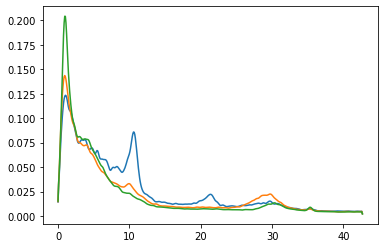

In [23]:
plt.plot(freqs, psds[0][0].T)

In [24]:
data["time_axis"][::downsamp_rate].shape

(598,)

In [25]:
(gamma.shape[0]+9)/n_trials

598.0

In [26]:
# Save the states timecourses and PSDs thanks to xarray and netCDF
print("Saving the states timecourses and PSDs")
tcourse = np.concatenate(
    (np.zeros((abs(lags[0]),n_states)), gamma, np.zeros((lags[-1],n_states)))
)
time_axis = data["time_axis"][::downsamp_rate]
t_len = time_axis.shape[0]
tcourse_trials = np.zeros((n_trials, t_len, n_states))
for tr in range(n_trials):
    tcourse_trials[tr] = tcourse[tr*t_len:(tr+1)*t_len]
ds = xr.Dataset(
    {
        "states_timecourse": (("trials","time", "states"), tcourse_trials),
        "states_psd": (("IC", "states", "freq"), np.concatenate((psds))),
    },
    {
        "IC":IC_list,
        "time":time_axis,
        "states":np.arange(1, n_states+1),
        "freq": freqs,
    }
)
ds.to_netcdf(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data.nc")
print(f"subj{subj}, IC{IC}: OK")

Saving the states timecourses and PSDs
subj2, IC4: OK


In [27]:
time_axis.shape

(598,)

In [28]:
ds

<xarray.Dataset>
Dimensions:            (IC: 4, freq: 501, states: 3, time: 598, trials: 675)
Coordinates:
  * IC                 (IC) int64 1 2 3 4
  * time               (time) float64 -4.0 -3.988 -3.977 ... 2.973 2.984 2.996
  * states             (states) int64 1 2 3
  * freq               (freq) float64 0.0 0.08533 0.1707 ... 42.5 42.58 42.67
Dimensions without coordinates: trials
Data variables:
    states_timecourse  (trials, time, states) float64 0.0 0.0 0.0 ... 0.0 0.0
    states_psd         (IC, states, freq) float64 0.01425 0.03241 ... 0.001103

In [29]:
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data.nc")
ds = ds.assign(frac_occ = (ds["states_timecourse"].sum("trials")/ds.sizes["trials"]))

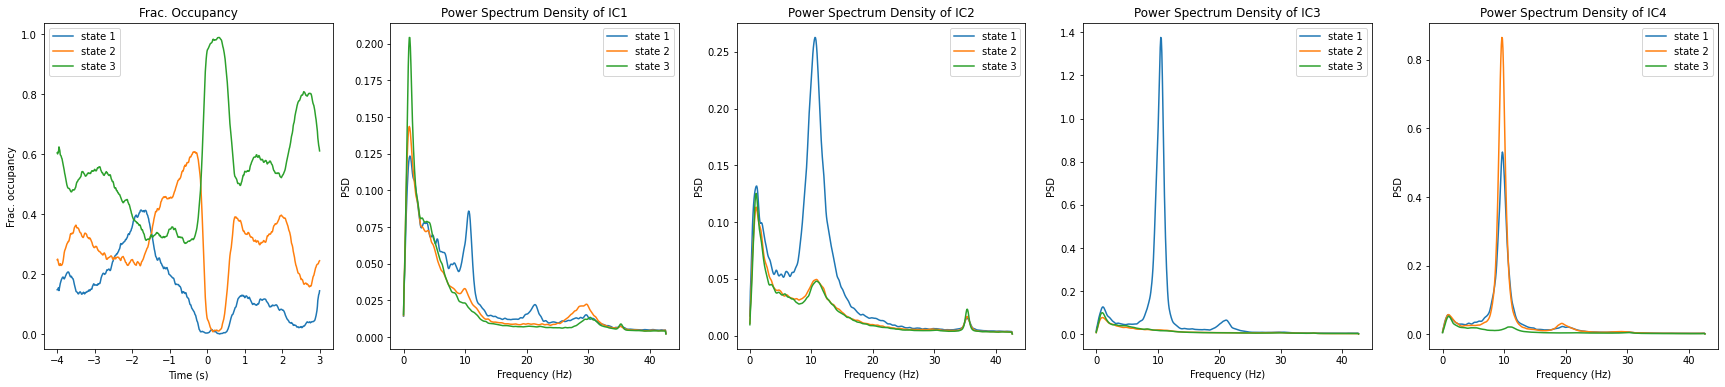

In [30]:
labels = [f"state {state}" for state in ds["states"].values]
fig = plt.figure(figsize=(6*(len(ds["IC"].values)+1),6))
plt.subplot(1, len(ds["IC"].values)+1, 1)
plt.title(f'Frac. Occupancy')
plt.plot(ds["time"].values, ds["frac_occ"].values)
plt.xlabel('Time (s)')
plt.ylabel('Frac. occupancy')
plt.legend(labels, loc='upper left')
for i in range(len(ds["IC"].values)):
    plt.subplot(1, len(ds["IC"].values)+1, i+2)
    plt.title(f"Power Spectrum Density of IC{ds['IC'].values[i]}")
    plt.plot(ds["freq"], ds["states_psd"].values[i,].T)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.legend(labels, loc='upper right')

In [31]:
ds.to_netcdf(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc", mode="w")
print(f"su{subj}, {n_states} states done")

su2, 3 states done


In [32]:
widths = [14, 1, 5]
heights = [1,1,1,4,4,4,4]

In [41]:
heights = [1 for i in range(n_states)] + [4,4,4,4]
heights

[1, 1, 1, 4, 4, 4, 4]

In [35]:
gs_kw = dict(width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['eeg'])

In [36]:
fig, f_axes = plt.subplots(figsize=(sum(widths),sum(heights)), ncols=3, nrows=(n_states+4), constrained_layout=True,
                         gridspec_kw=gs_kw)
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc")
for state in ds["states"].values:
    ax = f_axes[state-1,0]
#         ax.set_xticks([])
    ax.plot(ds["time"].values, ds["frac_occ"].values[:, state-1], color=f"C{state-1}")
    ax.set_xlim([-4, 3])
    ax.set_ylabel(f"state {state}")
for IC in ds["IC"].values:
    ax = f_axes[IC+n_states-1,0]
    data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
    tfr = wavelet_transform2(data, info, trial=np.arange(1,n_trials+1))
    mappable = ax.imshow(tfr[0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], 
                           norm=colors.PowerNorm(gamma=0.5), cmap='RdYlBu_r')
    ax.set_ylabel(f'Frequencies IC{IC} (Hz)')
    fig.colorbar(mappable, cax=f_axes[IC+n_states-1,1])
#         if IC!=4:
#             ax.set_xticks([])
for i in range(len(ds["IC"].values)):
    IC = ds["IC"].values[i]
    ax = f_axes[IC+n_states-1,2]
    ax.plot(ds["freq"].values, ds["states_psd"].values[i,].T)
    ax.set_ylabel(f'PSD IC{IC}')
ax = f_axes[n_states,2]
lines = ax.get_lines()
labels = [f"State {i}" for i in range (1, n_states+1)]
ax = f_axes[0,2]
ax.legend(lines, labels, loc='upper left')
ax = f_axes[n_states+3,0]
ax.set_xlabel(f'Time (s)') 
ax = f_axes[n_states+3,2]
ax.set_xlabel(f'Frequency (Hz)')   

fig.savefig(target_dir + f'grid-{n_states}states-subj{subj}_woPCA.png', dpi=300)
plt.close(fig)

Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse


In [37]:
n_trials_to_plot = 5

In [38]:
fig, f_axes = plt.subplots(figsize=(20,n_states*n_trials_to_plot), ncols=1, nrows=(n_states*n_trials_to_plot), constrained_layout=True)
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_woPCA_data_Multi.nc")
for state in range(1, n_states+1):
    color = f"C{state-1}"
    for trial in range(1, n_trials_to_plot+1):
        ax = f_axes[n_trials_to_plot*(state-1)+trial-1]
        ax.fill_between(ds["time"], ds["states_timecourse"].values[trial, :, state-1], color=color)
        ax.set_xlim([-4, 3])
        ax.set_ylim([0, 1])
        ax.set_ylabel(f"Prob. st{state} tr{trial}")
ax.set_xlabel("Time (s)")
fig.savefig(target_dir + f'tcourses-{n_states}states-subj{subj}_woPCA.png', dpi=300)
plt.close(fig)